In [90]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
# from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
import difflib
from PIL import Image
import easyocr



In [91]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)


def match_org(text, org_type):
    match_value = []
    if org_type == "ja":
        places_name = [
            "静岡",
            "福岡",
            "福島",
            "岐阜",
            "群馬",
            "広島",
            "金沢",
            "北見",
            "高知",
            "新潟市",
            "帯広",
            "大分",
            "徳島",
            "富山",
            "宇都宮",
            "岡山",
            "札幌",
            "仙台",
            "沼津",
            "千葉",
            "山梨",
            "多摩",
            "大阪",
            "横浜",
            "前橋",
            "練馬",
            "和歌山",
            "神戸" , 
            "宮崎", 
            "埼玉",
            "熊谷",
            "品川",
            "奈良",
            "足立" , 
            "京都",
            "なにわ" , 
            "姫路" ,
            "川崎",
            "野田",
            "長野"
        ]
    for x in places_name:
        sequence = difflib.SequenceMatcher(isjunk=None, a=x, b=text)
        difference = sequence.ratio()
        match_value.append(difference)
    confidence = max(match_value)
    print(f"{org_type} Org matching confidence: {confidence}")
    a = match_value.index(confidence)
    organization_name = places_name[a]
    return organization_name if confidence else ""

In [92]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [93]:

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    print(final_labels_frontal[0].wh())
    print((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]))
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.46) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor


def detect_lp(model, I, max_dim, lp_threshold):
    print(f"I.shape {I.shape}")
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img 
    print("Factor",factor)
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor ).astype(int).tolist()
    print(f"w,h {w}, {h}")
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    print("COr",Cor)
    return L, TLp, lp_type, Cor



Ration  1.0049751243781095
611
608
I.shape (606, 603, 3)
Factor 1.0082918739635158
w,h 608, 611
[0.28609286 0.1270698 ]
2.251462371244915
COr [array([[180.01885217, 352.53284873, 360.89612281, 188.38212626],
       [392.63708036, 323.02081461, 400.02511073, 469.64137648],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]
Cor [array([[180.01885217, 352.53284873, 360.89612281, 188.38212626],
       [392.63708036, 323.02081461, 400.02511073, 469.64137648],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]
[[180.01885217 352.53284873 360.89612281 188.38212626]
 [392.63708036 323.02081461 400.02511073 469.64137648]
 [  1.           1.           1.           1.        ]]
LPT IMG  [[[0.54117647 0.70196078 0.78039216]
  [0.54117647 0.70196078 0.78039216]
  [0.54117647 0.70196078 0.78039216]
  ...
  [0.08835784 0.32009804 0.12519148]
  [0.04558824 0.37941176 0.08089767]
  [0.06449142 0.47758119 0.09865579]]

 [[0.54117647 0.70196078 0.78039216]
  [0.54117647 0.

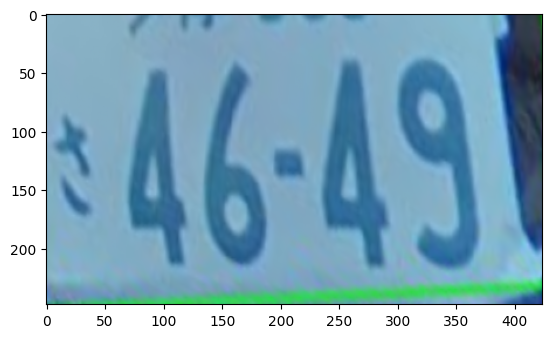

In [94]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2]) 
    print("Ration ",ratio)
    side = int(ratio * Dmin)
    print(side)
    bound_dim = min(side, Dmax) 
    print(bound_dim)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    print("Cor",cor)
    return vehicle, LpImg, cor
test_image_path = "plates/real_test04.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)
print(cor[0])
print("LPT IMG ", LpImg[0])
# fig = plt.figure(figsize=(12,6)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[0])
# plt.axis(False)
# plt.imshow(vehicle)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[1])
# plt.axis(False)
LpImg[0] = cv2.resize(LpImg[0], (424,248))
plt.imshow(LpImg[0])

In [95]:

# Create a numpy array from your data
data = np.array(LpImg[0])

# Multiply by 255 to convert to 8-bit values
data = (data * 255).astype(np.uint8)

# Create a PIL image from the numpy array
img = Image.fromarray(data)

# Save the image as a file
img.save('testing123.png')

# Initialize the EasyOCR reader
reader = easyocr.Reader([ 'ja',],recog_network='japanese_g2',)

# Load the image
# Perform OCR on the image
result = reader.readtext('testing123.png',paragraph=False,detail = 0)
print(result)

['さ', '4649']


In [96]:
def match_kana(text) : 
    match_kana = [] 
    kana_text = ["あ","い","う","え","か","き","く","け","の","こ","を" , "さ","す","せ","そ","た-と","な-の","は","ひ","ふ","ほ","ま-も","や","ゆ","ら","り","る"]
    for x in kana_text:
        sequence = difflib.SequenceMatcher(isjunk=None, a=x, b=text)
        difference = sequence.ratio()
        match_kana.append(difference)
    confidence = max(match_kana)
    print(f" Kana matching confidence: {confidence}")
    a = match_kana.index(confidence)
    kana_name = kana_text[a]
    return kana_name if confidence else ""

In [97]:
classic_kana = ""
license_plateNumber = ""
if len(result) == 2 : 

    print("DETECTED 2 Length")
    for i in result[1]:
        if i.isdigit() :
            license_plateNumber += i
        else: 
            classic_kana += i 
    classic_kana = match_kana(classic_kana)
elif len(result) == 3 : 
    print("DECTED 3 length") 
    classic_kana = match_kana(result[1])



DETECTED 2 Length
 Kana matching confidence: 0.0


In [98]:
classic_placesName = ""
classic_number = ""
for i in result[0] : 
    if i.isdigit() : 
        classic_number += i
    else:
        classic_placesName += i
print("Places Name" , match_org(result[0],'ja')) 
print("Number", classic_number)
print("Kana", classic_kana)
print("License Plate Number", license_plateNumber)

ja Org matching confidence: 0.0
Places Name 
Number 
Kana 
License Plate Number 4649
